# Spaceship Titanic Challenge
Ally Devico
https://www.kaggle.com/competitions/spaceship-titanic

In [1]:
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

EXPLORATORY DATA ANALYSIS

In [2]:
train = pd.read_csv('../data/spaceship-titanic/train.csv')
test = pd.read_csv('../data/spaceship-titanic/test.csv')

In [3]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
import seaborn as sns

In [6]:
numeric_cols = train.drop(['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Name', "CryoSleep", "VIP"], axis=1)

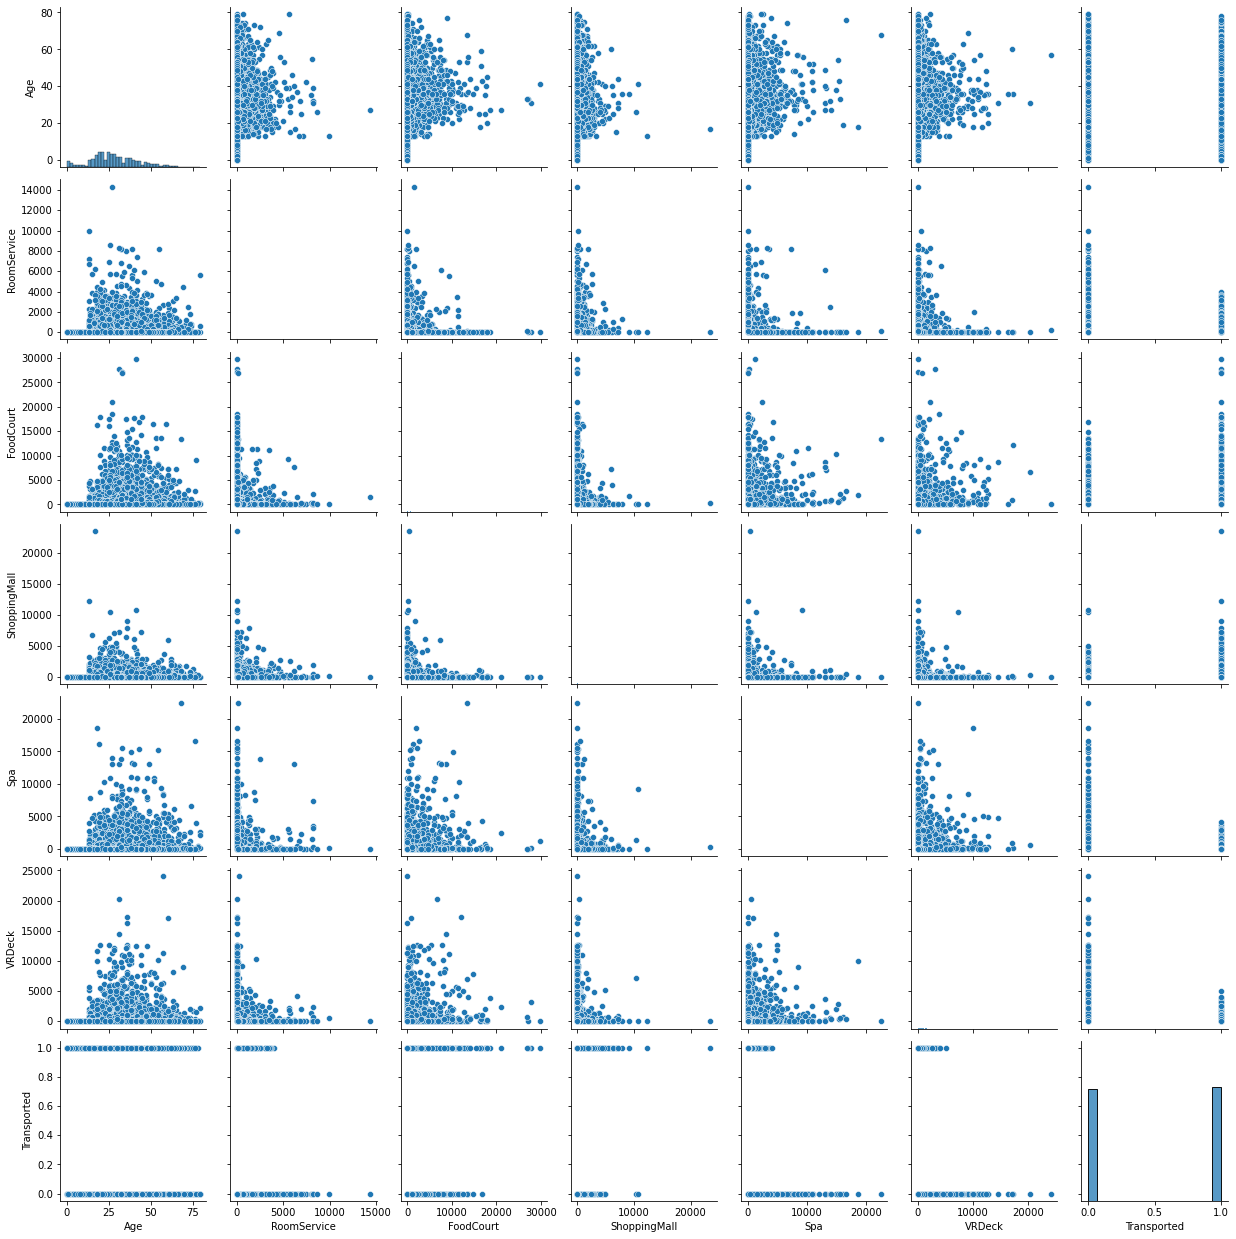

In [7]:
sns.pairplot(numeric_cols)

<AxesSubplot:xlabel='Age', ylabel='Count'>

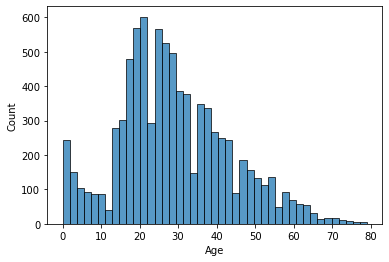

In [8]:
sns.histplot(train['Age'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

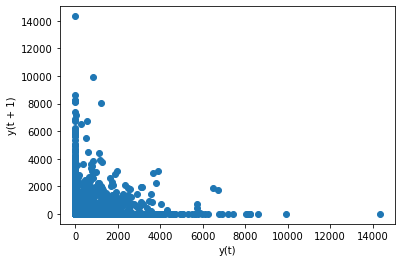

In [9]:
pd.plotting.lag_plot(train['RoomService'])

ORGANIZING / CLEANING DATA TRAIN DATA

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [11]:
label_encoder = LabelEncoder()
train['HomePlanet'] = label_encoder.fit_transform(train['HomePlanet'])
train['Cabin'] = label_encoder.fit_transform(train['Cabin'])
train['Destination'] = label_encoder.fit_transform(train['Destination'])

In [12]:
train.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep       217
Cabin             0
Destination       0
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [13]:
categorical_columns = ['CryoSleep','VIP', 'PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Name', "VIP", "CryoSleep"]

In [14]:
for col in categorical_columns:
    train[col].fillna(train[col].mode()[0], inplace=True)

In [15]:
for col in numeric_cols:
    train[col].fillna(train[col].median(), inplace=True)

In [16]:
train.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

PREDICTIVE MODELING

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [18]:
categorical_columns

['CryoSleep',
 'VIP',
 'PassengerId',
 'HomePlanet',
 'Cabin',
 'Destination',
 'Name',
 'VIP',
 'CryoSleep']

In [36]:
features = ['RoomService', 'FoodCourt', 'VIP', "Spa", "Age", "HomePlanet", "VRDeck", "CryoSleep"]
X = train[features]
y = train['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["RoomService", "FoodCourt", "Spa", "Age", "VRDeck"]),
        ('cat', OneHotEncoder(), ["VIP", "HomePlanet", "CryoSleep"])
    ])

rf_classifier = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(preprocessor.fit_transform(X_train), y_train)

best_rf_classifier = grid_search.best_estimator_

dt_classifier = DecisionTreeClassifier(random_state=30, max_depth=5, min_samples_split=5)

voting_classifier = VotingClassifier(estimators=[
    ('rf', best_rf_classifier),
    ('dt', dt_classifier)
], voting='hard')


model = make_pipeline(preprocessor, voting_classifier)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, predictions))

/Users/allydevico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/allydevico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/allydevico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/allydevico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarn

Accuracy: 0.7797584818861415
Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.77      0.78       861
        True       0.78      0.79      0.78       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



/Users/allydevico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


ORGANIZING / CLEANING TEST DATA

In [47]:
label_encoder = LabelEncoder()
test['HomePlanet'] = label_encoder.fit_transform(test['HomePlanet'])
test['Cabin'] = label_encoder.fit_transform(test['Cabin'])
test['Destination'] = label_encoder.fit_transform(test['Destination'])

In [48]:
for col in numeric_cols:
    if col != "Transported":
        test[col].fillna(test[col].median(), inplace=True)

In [49]:
for col in categorical_columns:
    test[col].fillna(test[col].mode()[0], inplace=True)

In [50]:
train.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [51]:
X_test_data = test[features]

In [52]:
y_test_pred = model.predict(X_test_data)

/Users/allydevico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


SAVING AS CSV

In [53]:
submission = pd.DataFrame({
    'PassengerId': test.PassengerId,
    'Transported': y_test_pred
})

submission.to_csv('submission.csv', index=False)
